In [2]:
!pip3 install catboost

In [5]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install sklearn


  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=d379f906c47a4d4dddb6e65e6338dfb15731e3b0431d2d5277b0e6929a68e16c
  Stored in directory: c:\users\laravieira\appdata\local\pip\cache\wheels\e4\7b\98\b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [1]:
# ??? O que está causando problema com importação de catboost e SplineTransformer?
# tentar instalar uma versão mais antiga de sklearn?
# https://github.com/mindsdb/lightwood/issues/75?ref=pythonrepo.com
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cat
from sklearn import linear_model as lm
from sklearn import preprocessing
from sklearn.preprocessing import SplineTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

# Séries Temporais
No contexto de análise e ciência de dados, séries temporais são dados observados de forma sequencial, em intervalos regulares ou irregulares. Muitas vezes esses dados são resultado de agregações feitas por um campo de data: podemos construir a série temporal do número de itens vendidos pelo Olist por dia, ou então o número de ataques de tubarão for mês.

# Dataset

Vamos continuar a análise do conjunto de dados de cancelamentos de reservas em 2 hotéis europeus. No entanto, enquanto no case de sábado passado fizemos uma análise baseada no dado transacional (cada individuo de nossa tabela era uma reserva) hoje agregaremos este dado e analisaremos o resultado agregado diário para um dos hotéis.

Primeiro vamos carregar o conjunto de dados de hotéis e transformar a informação de data em campos datetime. Isso nos permitirá calcular a data na qual a reserva foi feita.

In [5]:
# Link: https://www.sciencedirect.com/science/article/pii/S2352340918315191
tb_hotel = pd.read_csv("tb_hotel_completa.csv")
tb_hotel.head()

,Unnamed: 0,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,id_booking
0,0,Resort Hotel,0,342,0,0,2,0.0,0,BB,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,0
1,1,Resort Hotel,0,737,0,0,2,0.0,0,BB,...,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,1
2,2,Resort Hotel,0,7,0,1,1,0.0,0,BB,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2
3,3,Resort Hotel,0,13,0,1,1,0.0,0,BB,...,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,3
4,4,Resort Hotel,0,14,0,2,2,0.0,0,BB,...,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,4


In [6]:

tb_hotel["arrival_dt"] = pd.to_datetime(tb_hotel["arrival_date"])
tb_hotel["update_dt"] = pd.to_datetime(tb_hotel["reservation_status_date"])
tb_hotel["reserva_dt"] = tb_hotel["arrival_dt"] - pd.to_timedelta(
    tb_hotel["lead_time"], unit="d"
)

In [25]:
#checando se para as reservas canceladas o arrival date é diferente de zero
tb_hotel_check_arrival_date = tb_hotel[tb_hotel["is_canceled"]==1].copy()
tb_hotel_check_arrival_date.head()

,Unnamed: 0,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,id_booking,arrival_dt,update_dt,reserva_dt
8,8,Resort Hotel,1,85,0,3,2,0.0,0,BB,...,82.0,0,1,Canceled,2015-05-06,2015-07-01,8,2015-07-01,2015-05-06,2015-04-07
9,9,Resort Hotel,1,75,0,3,2,0.0,0,HB,...,105.5,0,0,Canceled,2015-04-22,2015-07-01,9,2015-07-01,2015-04-22,2015-04-17
10,10,Resort Hotel,1,23,0,4,2,0.0,0,BB,...,123.0,0,0,Canceled,2015-06-23,2015-07-01,10,2015-07-01,2015-06-23,2015-06-08
27,27,Resort Hotel,1,60,2,5,2,0.0,0,BB,...,107.0,0,2,Canceled,2015-05-11,2015-07-01,27,2015-07-01,2015-05-11,2015-05-02
32,32,Resort Hotel,1,96,2,8,2,0.0,0,BB,...,108.3,0,2,Canceled,2015-05-29,2015-07-01,32,2015-07-01,2015-05-29,2015-03-27


Para construir a série temporal de cancelamentos e reservas precisamos decidir por qual campo de data agregaremos nossos dados:

1. **Data de Chegada**
1. **Data da Reserva**
1. **Data da Última Atualização da Reserva**

Essa opção é algo comum quando construímos séries temporais (no âmbito de produtos por exemplo podemos ver as datas de compra, de faturamento e de entrega por exemplo). Por enquanto limitaremos a análise à **data de chegada**.

In [7]:
tb_resort = tb_hotel[tb_hotel["hotel"] == "Resort Hotel"]
tb_resort_ts = (
    tb_resort.groupby("arrival_dt")
    .agg(
        num_reservas=pd.NamedAgg("id_booking", "count"),
        num_canceladas=pd.NamedAgg("is_canceled", "sum"),
    )
    .reset_index()
)
tb_resort_ts.head()


,arrival_dt,num_reservas,num_canceladas
0,2015-07-01,43,5
1,2015-07-02,44,9
2,2015-07-03,40,13
3,2015-07-04,50,14
4,2015-07-05,45,8


In [8]:
tb_resort_ts["per_canceladas"] = (
    tb_resort_ts["num_canceladas"] / tb_resort_ts["num_reservas"]
)
tb_resort_ts.head()

,arrival_dt,num_reservas,num_canceladas,per_canceladas
0,2015-07-01,43,5,0.116279
1,2015-07-02,44,9,0.204545
2,2015-07-03,40,13,0.325000
3,2015-07-04,50,14,0.280000
4,2015-07-05,45,8,0.177778


A forma mais comum de visualizar dados de série temporal é através de **lineplots** onde o tempo é colocado no eixo X e as variáveis a serem analisadas no eixo Y.

Text(0.5, 0.95, 'Evolução de Reservas por Data de Chegada')

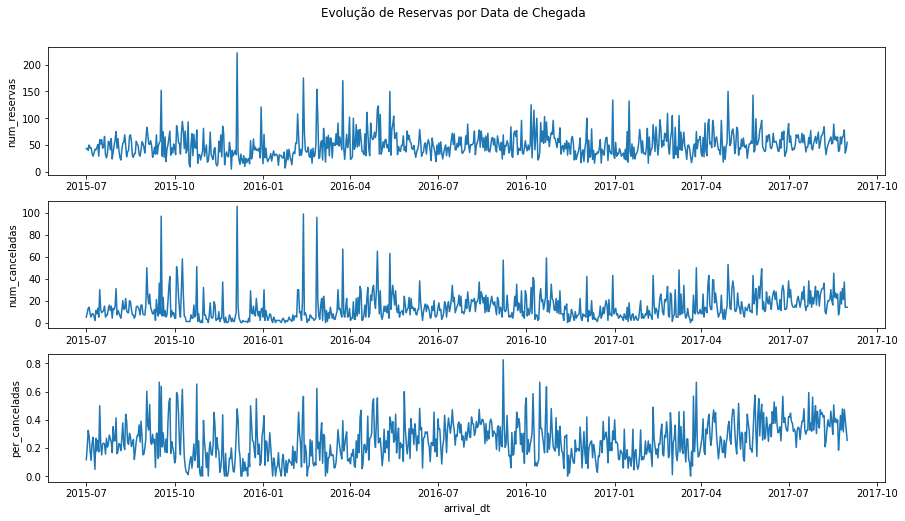

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="num_reservas", ax=ax[0])
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="num_canceladas", ax=ax[1])
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="per_canceladas", ax=ax[2])
ax[0].set_xlabel("")
ax[1].set_xlabel("")
fig.suptitle("Evolução de Reservas por Data de Chegada", y=0.95)


## Train & Test para séries temporais
A nossa estratégia tradicional para divisão de um dataset em train e test não funciona em séries temporais: como elas são definidas pela sequencialidade das observações, remover pontos aleatórios de dentro da série seria estranho... A forma mais simples e tradicional de se fazer essa divisão é selecionando pontos no fim da série como nosso conjunto teste. No exemplo acima optei por formar o conjunto de train a partir dos dois primeiros anos continuos que temos na série (veremos porque quando olharmos componentes sazonais).

In [10]:
tb_resort_ts["arrival_dt"].describe()


C:\Users\LARAVI~1\AppData\Local\Temp/ipykernel_17304/944963118.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tb_resort_ts["arrival_dt"].describe()


count                     793
unique                    793
top       2015-07-01 00:00:00
freq                        1
first     2015-07-01 00:00:00
last      2017-08-31 00:00:00
Name: arrival_dt, dtype: object

Ao invés de realizar a transformação agora, vamos definir uma função que realiza essa divisão para nós. Dessa forma não precisamos replicar nosso feature engineering em 2 datasets o tempo todo.

In [11]:
def split_hotel_ts(hotel_data):
    train_data = hotel_data[hotel_data["arrival_dt"] < "2017-08-01"].copy()
    test_data = hotel_data[hotel_data["arrival_dt"] >= "2017-08-01"].copy()
    return train_data, test_data


# Decomposição TCSI

A forma mais tradicional de se analisar um série temporal é através da decomposição TCSI:

1. **T - Componente de Tendência (Trend):** representação da evolução a longo prazo da série (*a taxa de cancelamento está crescendo ou caindo?*)
1. **C - Componente Ciclico (Cyclic)** representação da evolução ciclica não periódicas (*depois de altas de cancelamento tenho baixas?*)
1. **S - Componente Sazonal (Seasonal)** representação da peridiocidade sazonal (ciclo regular) (*temos mais cancelamento para reservas em junho? ou para reservas de segunda-feira? ou da última semana do mês?*)
1. **I - Componente de Ruído (Irregular/Noise)** o que não é representado pelos três componentes acima.

## Componente de Tendência (Trend)

In [12]:
tb_resort_ts["t_dias"] = (
    tb_resort_ts["arrival_dt"] - min(tb_resort_ts["arrival_dt"])
).dt.total_seconds() / (24 * 60 * 60)
tb_resort_ts.head()


,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias
0,2015-07-01,43,5,0.116279,0.0
1,2015-07-02,44,9,0.204545,1.0
2,2015-07-03,40,13,0.325000,2.0
3,2015-07-04,50,14,0.280000,3.0
4,2015-07-05,45,8,0.177778,4.0


### Estimativa de tendência linear

In [13]:
train_data, test_data = split_hotel_ts(tb_resort_ts)
trend_fit = lm.LinearRegression()
trend_fit.fit(train_data[["t_dias"]], train_data["per_canceladas"])


LinearRegression()

In [14]:
tb_resort_ts["pred_trend_linear"] = trend_fit.predict(tb_resort_ts[["t_dias"]])


Text(0.5, 0.95, 'Evolução de Reservas por Data de Chegada')

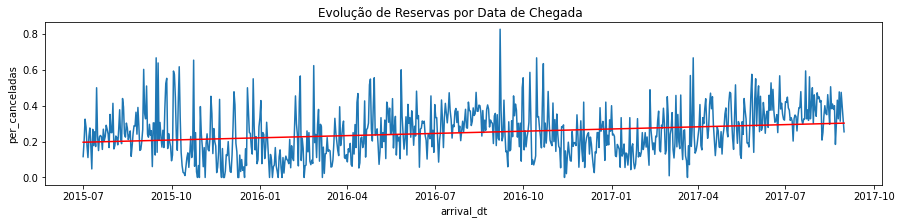

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts, x="arrival_dt", y="pred_trend_linear", color="red")
fig.suptitle("Evolução de Reservas por Data de Chegada", y=0.95)


## Componente Cíclico (Cycle)

Como os ciclos representam variações não-periódicas é dificil separa-los da avaliação de tendência (principalmente em séries curtas). Vamos utilizar três técnicas para estimar variações em relação a tendência.

### Tendência Polinomial

In [16]:
from sklearn.preprocessing import PolynomialFeatures


In [17]:
poly_trans = PolynomialFeatures(degree=2)
poly_trans.fit(train_data[["t_dias"]])


PolynomialFeatures()

In [18]:
poly_trans.n_output_features_


3

In [19]:
poly_names = ["P" + str(i) for i in range(poly_trans.n_output_features_)]
tb_resort_ts_p = pd.concat(
    [
        tb_resort_ts,
        pd.DataFrame(
            poly_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=poly_names,
        ),
    ],
    axis=1,
)
tb_resort_ts_p.head()


,arrival_dt,num_reservas,num_canceladas,per_canceladas,t_dias,pred_trend_linear,P0,P1,P2
0,2015-07-01,43,5,0.116279,0.0,0.196375,1.0,0.0,0.0
1,2015-07-02,44,9,0.204545,1.0,0.196509,1.0,1.0,1.0
2,2015-07-03,40,13,0.325000,2.0,0.196644,1.0,2.0,4.0
3,2015-07-04,50,14,0.280000,3.0,0.196778,1.0,3.0,9.0
4,2015-07-05,45,8,0.177778,4.0,0.196912,1.0,4.0,16.0


Text(0.5, 1.05, 'Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau 2')

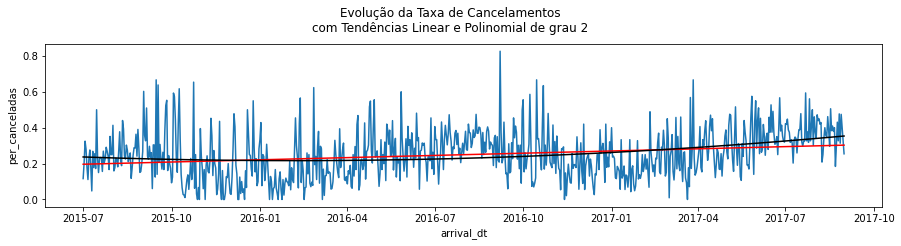

In [20]:
train_data, test_data = split_hotel_ts(tb_resort_ts_p)
poly_trend_fit = lm.LinearRegression()
poly_trend_fit.fit(train_data[poly_names], train_data["per_canceladas"])
tb_resort_ts_p["pred_trend_poly"] = poly_trend_fit.predict(tb_resort_ts_p[poly_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_p, x="arrival_dt", y="pred_trend_poly", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau {poly_trans.degree}",
    y=1.05,
)


In [22]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
# ??? >> pq ele não treina o modelo polinomial usando o t_dias, mas sim utilizando as colunas polinomiais que ele havia criado? 
test_data["pred_trend_poly"] = poly_trend_fit.predict(test_data[poly_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_poly = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_poly"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Poly.: {round(rmse_poly, 2)}")


Trend Lin.: 0.11
Trend Poly.: 0.08


### B-Splines

In [26]:
# Parei aqui. no vídeo da aula em 1:11
spl_trans = SplineTransformer(n_knots=24, extrapolation="constant")
spl_trans.fit(train_data[["t_dias"]])
spl_names = ["S" + str(i) for i in range(spl_trans.n_features_out_)]
tb_resort_ts_b = pd.concat(
    [
        tb_resort_ts,
        pd.DataFrame(
            spl_trans.transform(tb_resort_ts[["t_dias"]]),
            columns=spl_names,
        ),
    ],
    axis=1,
)
tb_resort_ts_b.head()
plt.plot(tb_resort_ts_b["S24"])


NameError: name 'SplineTransformer' is not defined

In [ ]:
train_data, test_data = split_hotel_ts(tb_resort_ts_b)
spline_fit = lm.LinearRegression()
spline_fit.fit(train_data[spl_names], train_data["per_canceladas"])
tb_resort_ts_b["pred_spline"] = spline_fit.predict(tb_resort_ts_b[spl_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines",
    y=1.05,
)


In [ ]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spl = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline: {round(rmse_spl, 2)}")


O que podemos melhorar aqui?

In [ ]:
train_data, test_data = split_hotel_ts(tb_resort_ts_b)
spline_fit = lm.Ridge()
spline_fit.fit(train_data[spl_names], train_data["per_canceladas"])
tb_resort_ts_b["pred_spline"] = spline_fit.predict(tb_resort_ts_b[spl_names])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e de Splines",
    y=1.05,
)


In [ ]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spl = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Spline.: {round(rmse_spl, 2)}")


## Componente Sazonal

### Variáveis Sazonais Contínuas

In [29]:
tb_resort_ts_b["s_semana"] = np.sin(tb_resort_ts_b["t_dias"] / (7 / np.pi))
tb_resort_ts_b["c_semana"] = np.cos(tb_resort_ts_b["t_dias"] / (7 / np.pi))

tb_resort_ts_b["s_mes"] = np.sin(tb_resort_ts_b["t_dias"] / (30.4 / np.pi))
tb_resort_ts_b["c_mes"] = np.cos(tb_resort_ts_b["t_dias"] / (30.4 / np.pi))

tb_resort_ts_b["s_ano"] = np.sin(tb_resort_ts_b["t_dias"] / (365 / np.pi))
tb_resort_ts_b["c_ano"] = np.cos(tb_resort_ts_b["t_dias"] / (365 / np.pi))


NameError: name 'tb_resort_ts_b' is not defined

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_semana", ax=ax[0])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_semana", ax=ax[0])

sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_mes", ax=ax[1])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_mes", ax=ax[1])

sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="s_ano", ax=ax[2])
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="c_ano", ax=ax[2])

ax[0].set_xlabel("")
ax[1].set_xlabel("")
fig.suptitle("Variáveis Contínuas Ciclicas", y=0.95)


In [ ]:
c_names = ["c_semana", "s_semana", "c_mes", "s_mes", "c_ano", "s_ano"]
spl_cycle = spl_names + c_names
train_data, test_data = split_hotel_ts(tb_resort_ts_b)
spl_cycle_fit = lm.Ridge()
spl_cycle_fit.fit(train_data[spl_cycle], train_data["per_canceladas"])
tb_resort_ts_b["pred_cycle_poly"] = spl_cycle_fit.predict(tb_resort_ts_b[spl_cycle])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_cycle_poly", color="red")
sns.lineplot(data=tb_resort_ts_b, x="arrival_dt", y="pred_spline", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Polinomial de grau {poly_trans.degree}",
    y=1.05,
)


In [ ]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_spline"] = spline_fit.predict(test_data[spl_names])
test_data["pred_trend_cycle"] = spl_cycle_fit.predict(test_data[spl_cycle])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_spline = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_spline"])
)
rmse_cycle = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_cycle"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend Poly.: {round(rmse_spline, 2)}")
print(f"Trend + Cycle: {round(rmse_cycle, 2)}")


### Variáveis Sazonais Dummy

In [28]:
tb_resort_ts_b["mes"] = tb_resort_ts_b["arrival_dt"].dt.month.astype(str)
tb_resort_ts_b["dia_semana"] = tb_resort_ts_b["arrival_dt"].dt.weekday.astype(str)


NameError: name 'tb_resort_ts_b' is not defined

In [ ]:
tb_resort_ts_b[["mes", "dia_semana"]]


In [ ]:
ohe_fit = OneHotEncoder(drop="first", sparse=False)
ohe_fit.fit(tb_resort_ts_b[["mes", "dia_semana"]])
tb_resort_ts_d = pd.concat(
    [
        tb_resort_ts_b,
        pd.DataFrame(
            ohe_fit.transform(tb_resort_ts_b[["mes", "dia_semana"]]),
            columns=ohe_fit.get_feature_names_out(),
        ),
    ],
    axis=1,
)


In [ ]:
tb_resort_ts_d.head()


In [ ]:
train_data, test_data = split_hotel_ts(tb_resort_ts_d)
dummy_names = list(ohe_fit.get_feature_names_out())
var_names = ["t_dias"] + dummy_names
season_trend_fit = lm.LinearRegression()
season_trend_fit.fit(train_data[var_names], train_data["per_canceladas"])

tb_resort_ts_d["pred_trend_season"] = season_trend_fit.predict(
    tb_resort_ts_d[var_names]
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_trend_linear", color="red")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_trend_season", color="black")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais",
    y=1.05,
)


In [ ]:
test_data["pred_trend_linear"] = trend_fit.predict(test_data[["t_dias"]])
test_data["pred_trend_season"] = season_trend_fit.predict(test_data[var_names])
rmse_lin = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_linear"])
)
rmse_cycle = np.sqrt(
    mean_squared_error(test_data["per_canceladas"], test_data["pred_trend_season"])
)
print(f"Trend Lin.: {round(rmse_lin, 2)}")
print(f"Trend + Season: {round(rmse_cycle, 2)}")


In [ ]:
train_data.columns


In [ ]:
final_list = spl_names + dummy_names + ["t_dias"]
X_train = train_data[final_list]
X_test = test_data[final_list]
y_train = train_data["per_canceladas"]
y_test = test_data["per_canceladas"]
scaler = StandardScaler()
scaler.fit(X_train)
cat_fit = cat.CatBoostRegressor(iterations=20000, depth=9, od_type="Iter", od_wait=1500)
cat_fit.fit(
    scaler.transform(X_train), y_train, eval_set=(scaler.transform(X_test), y_test)
)


In [ ]:
tb_resort_ts_d["pred_boosting"] = cat_fit.predict(
    scaler.transform(tb_resort_ts_d[final_list])
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="per_canceladas")
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="pred_boosting", color="red")
fig.suptitle(
    f"Evolução da Taxa de Cancelamentos\ncom Tendências Linear e Índices Sazonais utilizando Boosting",
    y=1.05,
)


## Exercício para tarde

No modelo de boosting acima utilizamos apenas as variáveis de spline, o componente linear e a as dummies sazonais. Será que conseguimos adicionar variáveis sazonais continuas ao modelo acima? Quais períodos deveriamos utilizar para essas variáveis? Crie uma rotina que permita o teste rápido de permutações entre os diferentes componentes temporais que vimos até agora e utilize-a para decidir quais o melhor conjunto de variáveis para o nosso modelo.

# Processos Auto-regressivos

## Autocorrelação e Autocorrelação Parcial

In [ ]:
tb_resort_ts_d["resid"] = (
    tb_resort_ts_d["per_canceladas"] - tb_resort_ts_d["pred_boosting"]
)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(data=tb_resort_ts_d, x="arrival_dt", y="resid")
fig.suptitle(
    f"Evolução dos Resíduos\nModelo de Boosting",
    y=1.05,
)


In [ ]:
tb_resort_ts_d["resid_lag"] = tb_resort_ts_d["resid"].shift(3)
tb_resort_ts_d[["resid", "resid_lag"]].head()


In [ ]:
sns.lmplot(
    data=tb_resort_ts_d[tb_resort_ts_d["arrival_dt"] >= "2017-08-01"],
    x="resid_lag",
    y="resid",
)
fig.suptitle(f"Diagrama de Fase dos Resíduos\n L=1", y=1.05)


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
plot_acf(tb_resort_ts_d["resid"], lags = range(1, 15));

In [ ]:
plot_pacf(tb_resort_ts_d["resid"], lags = range(1, 15), method = 'ywm');

## Os métodos Shift e Diff

Uma forma de tratar a auto-correlação é utilizar o histórico da propria variável modelada como variável de entrada. Podemos fazer isso neutralizando essa autocorrelação através da diferenças (Hoje - Ontem), ou então adicionar a variável *Ontem* ao modelo. **Devemos tomar cuidado pois isso muda o horizonte preditivo de nosso modelo!!**

In [ ]:
plot_acf(tb_resort_ts_d["per_canceladas"], lags = range(1, 15));

In [ ]:
tb_resort_ts_d[['per_canceladas']].diff().dropna()

In [ ]:
plot_acf(tb_resort_ts_d[['per_canceladas']].diff().dropna(), lags = range(1, 15));

## Modelos **A**(uto)**R**(egressive)**I**(ntegrated)**M**(oving)**A**(average)

Os modelos ARIMA são modelos lineares que incorporam as idéias apresentadas acima em um framework único de modelagem.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
arima_model = ARIMA(train_data['per_canceladas'], exog = train_data[dummy_names], order = (1,0,1))
arima_fit = arima_model.fit()
arima_fit.summary()

In [ ]:
tb_resort_ts_d['pred_arima'] = arima_fit.predict(exog = test_data[dummy_names])